# ДЗ№1 по Принятию решений в условиях неопределенности и риска

В данном исследовании рассматриваются две компании: Texas Instruments (TXN) и Domino’s Pizza (DPZ).
Цель работы — найти оптимальные портфели по критериям Value at Risk (VaR) и Conditional Value at Risk (CVaR),
а также сравнить их с эффективными портфелями по μ-σ предпочтениям.

## Определения:
- **Value at Risk (VaR)**: Это уровень потерь, который не превышается с вероятностью (1 - alpha).
- **Conditional Value at Risk (CVaR)**: Это среднее значение потерь при условии, что они превышают VaR.

In [ ]:
!pip install yfinance

In [ ]:
# Импорт библиотек
import typing as tp
import numpy as np
import cvxpy as cp
import seaborn as sns
import yfinance as yf
import matplotlib.pyplot as plt
sns.set_style("whitegrid")

## Загрузка данных

Используем исторические данные доходностей акций компаний **Texas Instruments (TXN)** и **Domino’s Pizza (DPZ)**. Данные получены из Yahoo Finance, выбраны 300 дней в спокойный период (без резких кризисных событий).

"Спокойный период"- это отрезок времени, когда рынок был относительно стабильным, без сильных скачков цен, кризисов или других внешних шоков.

Период с 01.01.2020 по 01.01.2021 был выбран, потому что на рынке отсутствовали значительные внешние шоки

Код для загрузки данных:

In [ ]:
def read_stock_data(tickers: list[str], start_date: str, end_date: str = None) -> np.ndarray:
    """
    Загружает данные о ценах закрытия акций с Yahoo Finance API.

    :param tickers: Список тикеров компаний.
    :param start_date: Дата начала периода.
    :param end_date: Дата окончания периода.
    :return: Массив доходностей акций.
    """
    data = yf.download(tickers, start=start_date, end=end_date)
    close_prices = data['Close']
    returns = (close_prices.shift(-1) / close_prices)[:-1]
    return returns

# Параметры
tickers = ['TXN', 'DPZ']
start_date = '2020-01-01'
end_date = '2021-01-01'

# Загрузка данных
data = read_stock_data(tickers, start_date, end_date)

[*********************100%***********************]  2 of 2 completed


# Построение выборочной функции распределения
Построим графики **выборочной функции распределения** (empirical CDF) для доходностей обеих компаний. Это позволит понять, как распределены доходности.

Код для построения графиков:

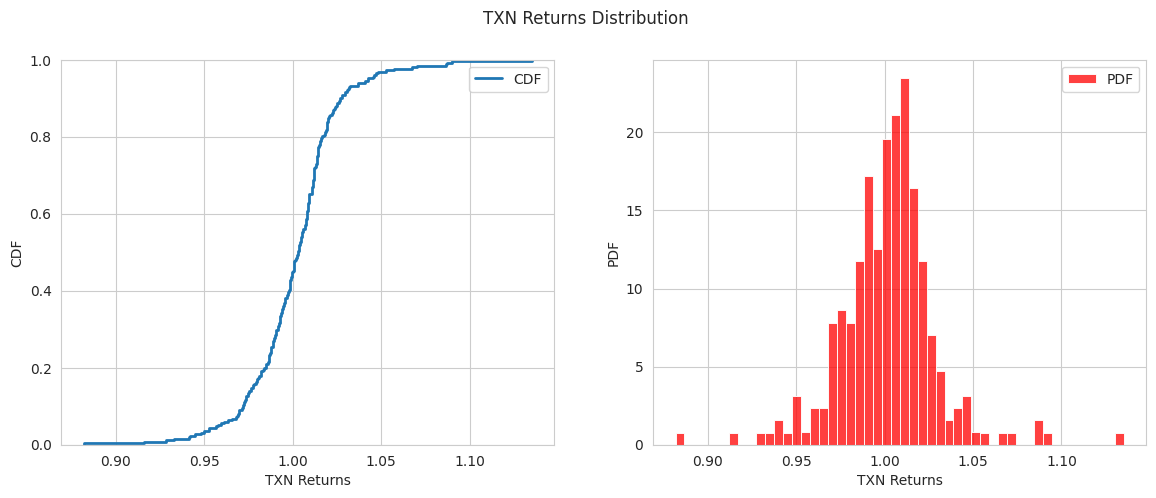

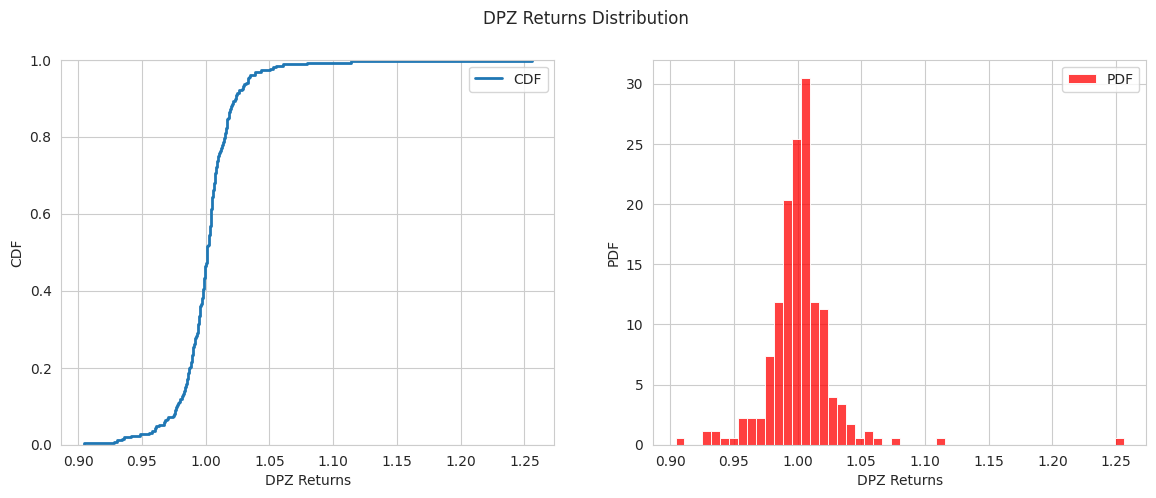

In [ ]:
def plot_stock(data: np.ndarray, ticker: str) -> None:
    """
    Строит графики распределения доходностей для указанного тикера.

    :param data: Массив данных.
    :param ticker: Тикер компании.
    """
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
    plt.suptitle(f'{ticker} Returns Distribution')
    sns.ecdfplot(data, ax=ax[0], label='CDF', linewidth=2)
    ax[0].legend()
    ax[0].set_ylabel('CDF')
    ax[0].set_xlabel(f'{ticker} Returns')
    sns.histplot(data, stat='density', ax=ax[1], label='PDF', color='red', bins=50)
    ax[1].legend()
    ax[1].set_ylabel('PDF')
    ax[1].set_xlabel(f'{ticker} Returns')
    plt.show()

def plot_tickers(data: np.ndarray, tickers: list[str]) -> None:
    """
    Строит графики распределения доходностей для списка тикеров.

    :param data: Массив данных.
    :param tickers: Список тикеров.
    """
    for tick in tickers:
        x = data[tick].to_numpy()
        plot_stock(x, tick)

# Построение графиков
plot_tickers(data, tickers)


Графики показывают, что доходности TXN имеют слабую положительную асимметрию, что указывает на наличие небольших потерь в хвостах распределения. Для DPZ распределение более симметрично, что говорит о меньшей вероятности экстремальных событий.

# Вычисление выборочных статистик
Теперь найдем основные статистические характеристики доходностей:

* Среднее значение
* Дисперсия
* Коэффициент корреляции
* Матрица ковариации

In [ ]:
def calculate_statistics(data: np.ndarray, tickers: list[str]):
    """
    Вычисляет выборочные статистики для данных.

    :param data: Массив данных.
    :param tickers: Список тикеров.
    :return: Средние значения, дисперсии, коэффициент корреляции и матрицу ковариации.
    """
    means = data.mean()
    variances = data.var()
    correlation = data.corr()[tickers[0]][tickers[1]]
    covariance = data.cov().to_numpy()
    return means, variances, correlation, covariance

# Расчет статистик
expected_returns, sigmas, corr, covariance = calculate_statistics(data, tickers)

# Вывод результатов
for m, s, tick in zip(expected_returns, sigmas, tickers):
    print(f'{tick}')
    print(f'Expected Return: {m:.6f}')
    print(f'Variance of Return: {s:.6f}\n')
print(f'Correlation Coefficient: {corr:.6f}')

TXN
Expected Return: 1.001455
Variance of Return: 0.000756

DPZ
Expected Return: 1.001421
Variance of Return: 0.000740

Correlation Coefficient: 0.352144


Средние значения доходностей TXN и DPZ практически одинаковы, что указывает на схожесть их производительности. Низкий коэффициент корреляции (0.352144) подтверждает слабую зависимость между активами, что может быть полезно для диверсификации портфеля

# Расчет VaR (Value at Risk) и расчет CVaR (Conditional VaR)
* VaR показывает максимальный возможный убыток при заданной вероятности (обычно 95%).

* CVaR измеряет средний убыток, превышающий VaR, т.е. насколько велики потери, если они оказались больше ожидаемых.

### Алгоритм расчета *VaR*

*VaRα*(*X*) = *q*1 − *α*
- квантиль распределения.

Для расчета по выборке используется `np.quantile(x, 1 - alpha)`, который возвращает

`q * (n - 1) + 1` элемент массива, в данном случае это `18.45` - между 18 и 19 элементами массива.

### Алгоритм расчета *CVaR*

$CVaR_{\alpha}(X) = \mathbb{E}[X | X < VaR_{\alpha}(X)$ - среднее значение при условии того, что величина меньше $VaR_{\alpha}(X)$.

Для расчета по выборке используется `np.mean` по части выборки, которая меньше рассчитанного $VaR_{\alpha}(X)$.

In [ ]:
def variance_at_risk(data: np.ndarray, alpha: float = 0.95) -> float:
    """
    Вычисляет Value at Risk (VaR) для выборки.

    :param data: Массив данных.
    :param alpha: Уровень доверия.
    :return: VaR.
    """
    return np.quantile(data, 1 - alpha)

def expected_shortfall(data: np.ndarray, alpha: float = 0.95) -> float:
    """
    Вычисляет Conditional Value at Risk (CVaR) для выборки.

    :param data: Массив данных.
    :param alpha: Уровень доверия.
    :return: CVaR.
    """
    var = variance_at_risk(data, alpha)
    return np.mean(data[data < var])

# Определение уровня доверия
alpha = 0.95
# Расчет VaR и CVaR
for tick in tickers:
    x = data[tick].to_numpy()
    print(f'{tick}, alpha = {alpha}')
    print(f'Value at Risk: {variance_at_risk(x, alpha):.6f}')
    print(f'Conditional Value at Risk: {expected_shortfall(x, alpha):.6f}\n')


TXN, alpha = 0.95
Value at Risk: 0.958837
Conditional Value at Risk: 0.938788

DPZ, alpha = 0.95
Value at Risk: 0.965400
Conditional Value at Risk: 0.944747



VaR для TXN ниже, чем для DPZ (0.958837 против 0.965400), что указывает на меньший риск потерь для TXN при уровне доверия 95%. Однако CVaR для TXN выше (0.938788 против 0.944747), что говорит о большей вероятности крупных убытков в случае возникновения хвостовых событий.

# Оптимизация портфеля по VaR и CVaR
Теперь найдем оптимальное распределение активов в портфеле, минимизируя VaR и CVaR.

In [ ]:
def optimize_by_step(f: tp.Callable[[float], float], step: float, start: float = 0, end: float = 1, maximize=True) -> float:
    """
    Находит оптимальное решение для скалярной функции методом перебора.

    :param f: Целевая функция.
    :param step: Шаг перебора.
    :param start: Начало интервала.
    :param end: Конец интервала.
    :param maximize: Флаг максимизации.
    :return: Оптимальное значение.
    """
    best = start
    best_value = None
    for x in np.arange(start, end + step, step):
        if best_value is None or (maximize and f(x) > best_value) or (not maximize and f(x) < best_value):
            best_value = f(x)
            best = x
    return best

# Оптимальный портфель по VaR
first, second = tickers
alpha = 0.95
x_var = optimize_by_step(
    lambda x: variance_at_risk(data[first] * x + data[second] * (1 - x), alpha),
    step=0.0005
)
w_var = np.array([x_var, 1 - x_var])
var_portfolio = {
    'coef': w_var,
    'mu': w_var @ expected_returns,
    'variance': w_var @ covariance @ w_var
}
print('Optimal by VaR Portfolio:')
print(f'{x_var:.5f} {first}, {1-x_var:.5f} {second}')
print(f'Expected Return: {var_portfolio["mu"]:.5f}')
print(f'Variance: {var_portfolio["variance"]:.5f}')

# Оптимальный портфель по CVaR
x_cvar = optimize_by_step(
    lambda x: expected_shortfall(data[first] * x + data[second] * (1 - x), alpha),
    step=0.0005
)
w_cvar = np.array([x_cvar, 1 - x_cvar])
cvar_portfolio = {
    'coef': w_cvar,
    'mu': w_cvar @ expected_returns,
    'variance': w_cvar @ covariance @ w_cvar
}
print('Optimal by CVaR Portfolio:')
print(f'{x_cvar:.5f} {first}, {1-x_cvar:.5f} {second}')
print(f'Expected Return: {cvar_portfolio["mu"]:.5f}')
print(f'Variance: {cvar_portfolio["variance"]:.5f}')

Optimal by VaR Portfolio:
0.31850 TXN, 0.68150 DPZ
Expected Return: 1.00143
Variance: 0.00053
Optimal by CVaR Portfolio:
0.45750 TXN, 0.54250 DPZ
Expected Return: 1.00144
Variance: 0.00051


Оптимальный портфель по VaR содержит больше DPZ (68.15%), так как этот актив имеет меньший уровень рисков при заданном уровне доверия. Оптимальный портфель по CVaR более сбалансирован (45.75% TXN, 54.25% DPZ), что отражает стремление минимизировать хвостовые риски.

## Расчет эффективной границы по критерию − предпочтений (наивныйперебор)

### Алгоритм перебора портфелей

С фиксированным шагом перебираем все портфели вида `(x, 1 - x)` для двух акций и рассчитываем для всех значения ожидаемой доходности и риска.

Затем перебираем все полученные портфели и ищем парето-оптимальные, то убираем все те, для которых есть хоть один доминирующий (по *μ* − *σ* критерию) портфель, простым перебором всех комбинаций.

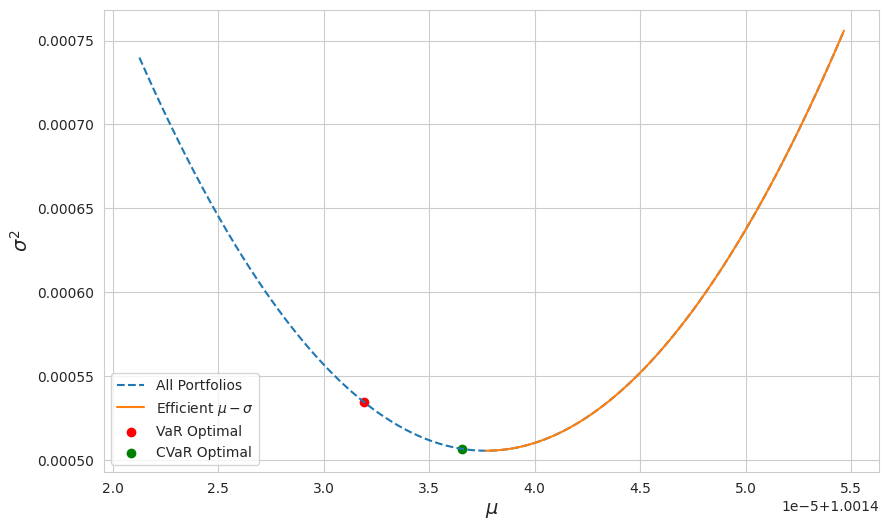

In [ ]:
def evaluate_by_step(expected_returns, covariance, step: float, start: float = 0, end: float = 1) -> np.ndarray:
    """
    Вычисляет ожидаемую доходность и дисперсию для всех портфелей на сетке.

    :param expected_returns: Ожидаемые доходности.
    :param covariance: Матрица ковариации.
    :param step: Шаг перебора.
    :param start: Начало интервала.
    :param end: Конец интервала.
    :return: Массив портфелей.
    """
    results = []
    for x in np.arange(start, end + step, step):
        w = np.array([x, 1 - x])
        mu = w @ expected_returns
        variance = w @ covariance @ w
        results.append([mu, variance])
    return np.array(results)

def pareto_efficient(data: np.ndarray) -> np.ndarray:
    """
    Находит Парето-оптимальные портфели.

    :param data: Массив портфелей.
    :return: Индексы Парето-оптимальных портфелей.
    """
    is_efficient = np.ones(data.shape[0], dtype=bool)
    for i, c in enumerate(data):
        if is_efficient[i]:
            is_efficient[is_efficient] = np.any(data[is_efficient] < c, axis=1)
            is_efficient[i] = True
    return is_efficient

# Вычисление всех портфелей
portfolios = evaluate_by_step(expected_returns, covariance, 0.0005)

# Нахождение Парето-оптимальных портфелей
costs = portfolios.copy()
costs[:, 0] *= -1
efficient_portfolios = portfolios[pareto_efficient(costs)]

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(portfolios[:, 0], portfolios[:, 1], label='All Portfolios', linestyle='--')
plt.plot(efficient_portfolios[:, 0], efficient_portfolios[:, 1], label='Efficient $\mu-\sigma$')
plt.scatter(var_portfolio["mu"], var_portfolio["variance"], label='VaR Optimal', color='red')
plt.scatter(cvar_portfolio["mu"], cvar_portfolio["variance"], label='CVaR Optimal', color='green')
plt.xlabel('$\mu$', fontsize=14)
plt.ylabel('$\sigma^2$', fontsize=14)
plt.legend()
plt.show()

Оба оптимальных портфеля (по VaR и CVaR) находятся на эффективной границе, что подтверждает их высокую эффективность. Однако портфель по VaR расположен ближе к левому краю графика, что указывает на меньший уровень риска при схожей доходности.